In [1]:
import auto_fitting as auto
import glob
import os
auto.plt.rcParams['figure.figsize'] = [11, 8]

In [2]:
filenames = glob.glob('/Users/ryanlindley/Research/CIV/*')
CIV_targets = []
for f in filenames:
    CIV_targets.append(f.replace('/Users/ryanlindley/Research/CIV/', ''))
    
print(CIV_targets)

['LBQS-0107-0235', 'LBQS-0107-0232', 'RXJ2154.1-4414', '1ES1553+113', 'PG0003+158', 'J1127+1154', 'MRK817', 'SDSSJ092554.43+453544.4', 'SDSSJ085116.14+424328.8', 'RXSJ00508+3536', 'PG0953+414', 'SDSSJ085259.22+031320.6', '4C-05.38', 'TON236', 'FBS0150+396', 'IZW1', 'MRK-1044', 'PHL1598', 'Q0349-146', '2MASX-J16194054+2543233', 'LBQS-1435-0134', 'PG-1338+416', 'FIRST-J020930.7-043826', 'RBS2005', 'PG1048+342', 'Q2135-145', 'RBS144', 'PG1121+422', 'MRK352', 'SDSS-J141038.39+230447.1', 'VV2006-J095243.0+515121', 'PKS0552-640', 'MR2251-178', 'Q2251+155', 'QSO-B1124+271', 'QSO0045+3926', 'J230837.73-525848.5', 'PMNJ1103-2329', 'B0117-2837', 'PG1216+069', 'CSO-0873', 'SDSSJ133053.27+311930.5', 'Q1545+210', 'RXS-J00057-5007', 'TONS210', 'QSO-B1435-0645', 'NGC7714', 'RBS1666', 'QSO-B0952+457', 'SDSSJ123235.82+060310.0', '1H-2129-624', 'PG1011-040', 'RBS1892', 'SDSSJ161916.54+334238.4', '1ES1028+511', 'PG-1630+377', 'SDSSJ135712.61+170444.1', '3C48', 'VIIZW244', 'PG1001+291', 'VV2006-J125901.7+

In [55]:
name = CIV_targets[3]
print(name)

1ES1553+113


In [56]:
directory = '/Users/ryanlindley/Research/CIV/' + name
os.chdir(directory)
os.getcwd()

'/Users/ryanlindley/Research/CIV/1ES1553+113'

In [57]:
wl1, f1, gamma1, elem, state = (1548.187, 0.19, 0.00324, 'C', 'IV')
wl2, f2, gamma2, elem, state = (1550.772, 0.0952, 0.00325, 'C', 'IV')

path = '/Users/ryanlindley/Research/CIV/' + name + '/CIV.bin3.linespec'
wl, fl, fe, ctn = auto.np.loadtxt(path).transpose()
lsf = auto.np.loadtxt('/Users/ryanlindley/Research/CIV.old_setup/CIV.lsf')

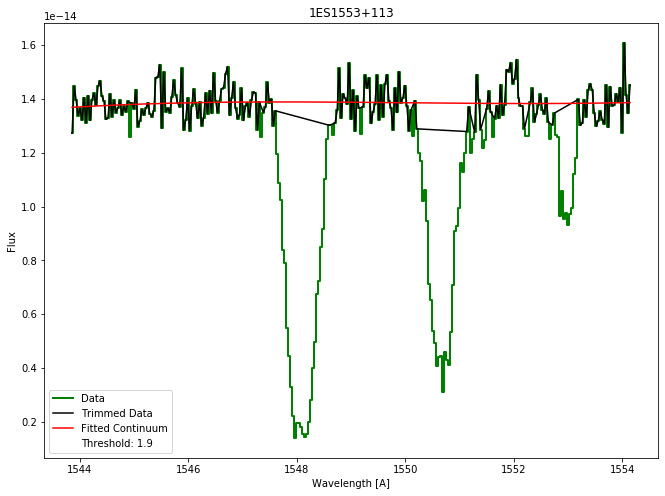

In [58]:
new_ctn = auto.find_continuum(name, wl, fl, fe, ctn, [True]*len(wl))

#ctn_flag = auto.mask_wl(wl, [1543, 1543.9, 1544.5, 1545, 1545.5, 1548.5, 1549.5, 1550.5])  # add custom ctn if needed 
#manual_ctn = auto.find_continuum(name, wl, fl, fe, ctn, ctn_flag)

In [59]:
#new_ctn = manual_ctn # only include when manual continuum us found

In [60]:
fn = fl / new_ctn
fne = fe / new_ctn

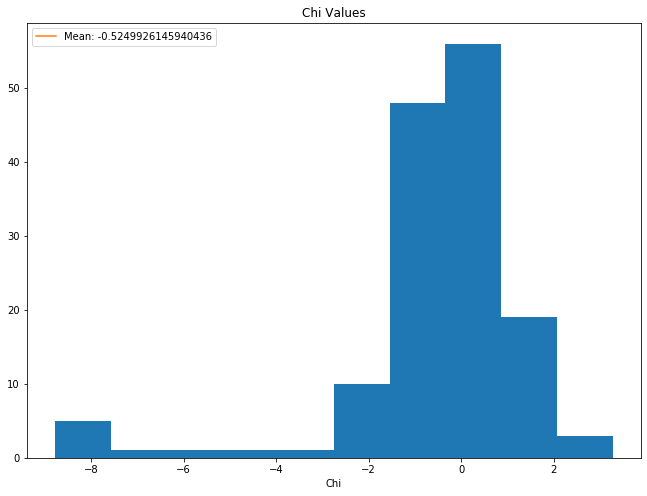

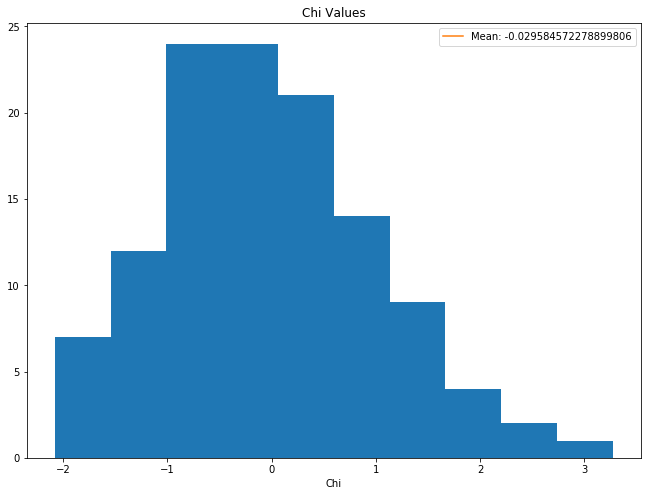

In [62]:
chi, chi_mean = auto.find_chi(wl, fl, fe, new_ctn)
auto.plot_chi_histogram(chi, chi_mean)

flag_chi = auto.mask_wl(wl, [1552.5, 1553.5]) # mask out regions for better calculation of chi histogram

new_chi, new_chi_mean = auto.find_chi(wl[flag_chi], fl[flag_chi], fe[flag_chi], new_ctn[flag_chi])
auto.plot_chi_histogram(new_chi, new_chi_mean)

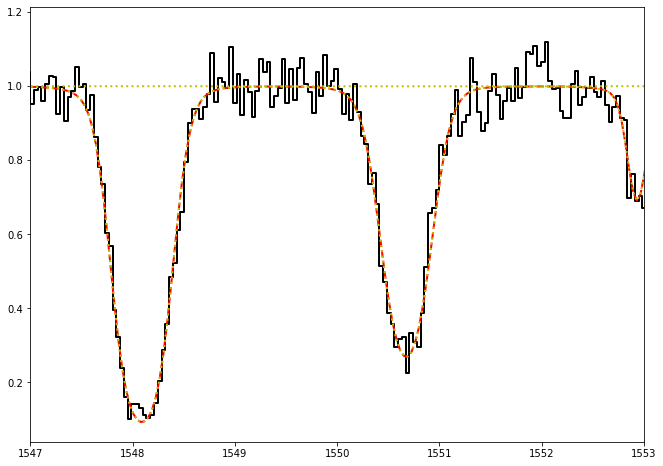

[ 14.52624302  47.92496132 -20.29846818  13.67904403  20.16320929
 416.31669288]


In [63]:
x0 = [13.5, 20.3, auto.Wave2V(1548, wl1)] + [13, 20.3, auto.Wave2V(1553, wl2)]

feat = [0, 2] #which features used to model 0 - both, 1 - strong, 2 - weak
p0, cov, a, b, c = auto.leastsq(auto.fitting, x0, full_output=1, args=(feat, wl, wl1, wl2, f1, f2, gamma1, gamma2, lsf, fn, fne))

auto.plot_model(p0, feat, wl, fn, wl1, wl2, f1, f2, gamma1, gamma2, lsf)
print(p0)

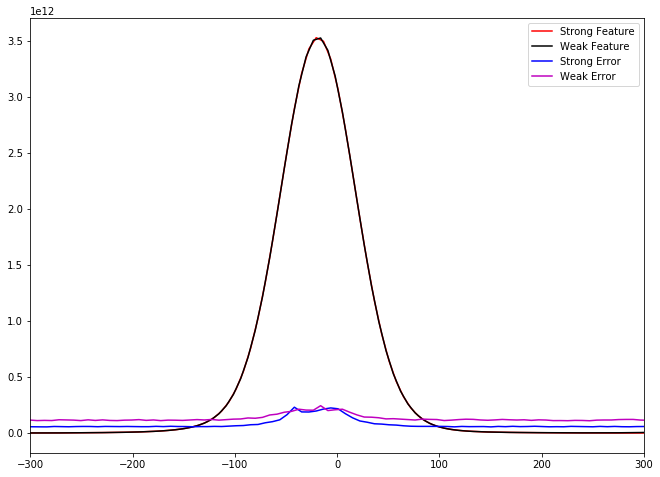

In [64]:
N1, N2 = auto.make_features(p0, feat, wl, wl1, wl2, lsf, gamma1, gamma2)
Ne1 = auto.nfle2Nev(fn, fne, f1, wl1)
Ne2 = auto.nfle2Nev(fn, fne, f2, wl2)
auto.plot_features(wl, wl1, wl2, N1, N2, Ne1, Ne2)

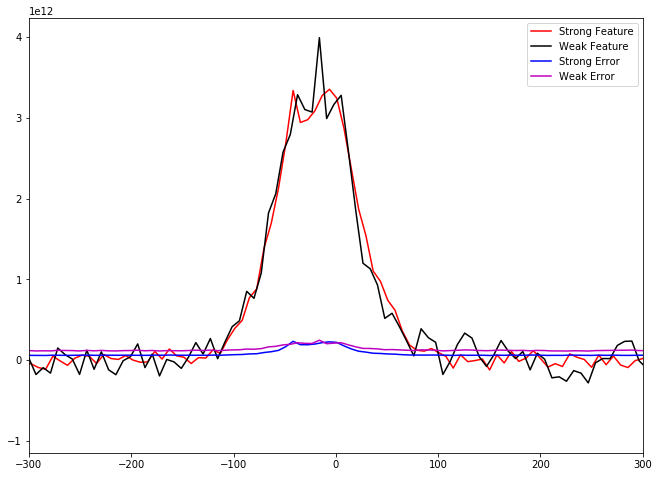

In [65]:
N1r, N2r = auto.add_residual(p0, N1, N2, feat, wl, wl1, wl2, f1, f2, gamma1, gamma2, lsf, fn)
auto.plot_features(wl, wl1, wl2, N1r, N2r, Ne1, Ne2)

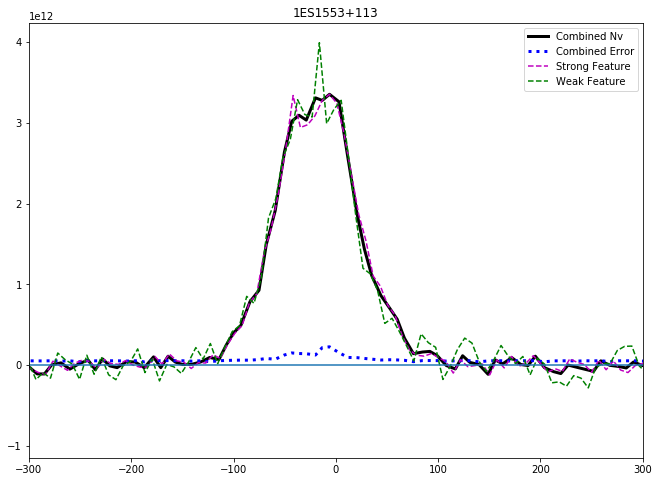

In [66]:
strong_flag = auto.mask_v(wl, wl1, []) # add masking for any regions not to be used in combined data
weak_flag = auto.mask_v(wl, wl2, [-10, 0])

v1, v2, Nv1, Nv2, Nve1, Nve2 = auto.remove_regions(strong_flag, weak_flag, wl, wl1, wl2, N1r, N2r, Ne1, Ne2)

v_bins, Nv_bins, Nve_bins = auto.make_bins(v1, v2, Nv1, Nv2, Nve1, Nve2)

v_final, Nv_final, Nve_final =  auto.final_data(v_bins, Nv_bins, Nve_bins)

auto.plot_final_data(wl, wl1, wl2, N1r, N2r, v_final, Nv_final, Nve_final, name)

In [67]:
N = auto.find_N(-115, 110, v_final, Nv_final)
print('Column Density: ', N)

Column Density:  14.790032029319137


In [68]:
auto.np.savetxt('CIV.N_v', Nv_final)
auto.np.savetxt('CIV.v', v_final)
auto.np.savetxt('CIV.Ne_v', Nve_final)
auto.save_final_data_plot(wl, wl1, wl2, N1r, N2r, v_final, Nv_final, Nve_final, name)
auto.save_final_continuum_data(wl, fl, new_ctn, name)